In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, recall_score, auc, r2_score, mean_absolute_error, mean_squared_error, precision_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from scipy.stats import random_correlation
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, precision_recall_curve

import numpy as np
import pandas as pd

from plotnine import *


In [103]:
def generate_correlation(p: int = 10) -> np.array:
    """Generate a correlation matrix based on a random vector of eigenvalues.

    Arguments:
        p (int): Dimensionality of the correlation matrix.

    Returns:
        A correlation matrix with shape (p, p).
    """

    p = int(p)
    assert(p > 1)
    # Generate some uniform random variables.
    u = np.random.uniform(size=p)
    # Scale the random numbers so that they sum to p.
    eigen = u * p / np.sum(u)
    # Return correlation.
    return random_correlation.rvs(eigen)

def generate_data(seed=13, n=1000, p=10, beta_range: list[float] = [0, 2], sigma: float = 1.0,
                  corr: np.array = None):
    """Generate random features and labels using a linear model.

    Arguments:
        seed (int): Seed for reproducibility.
        n (int): The number of samples.
        p (int): The number of parameters.
        beta_low (float): The lower bound of the coefficients.
        beta_high (float): The upper bound of the coefficients.
        sigma (float): Standard deviation of the normally distributed noise.

    Returns:
        A tuple (X, y, beta) containing the feature matrix, labels, and true betas.
    """
    p = int(p)
    if corr is None:
        covar = np.diag(np.full(p, sigma))
    else:
        assert(corr.shape[0] == p)
        assert(corr.shape[1] == p)
        covar = corr * sigma
  
    X = np.random.multivariate_normal(np.zeros(p), covar, n)

    beta = np.random.uniform(size = p, low = beta_range[0], high = beta_range[1])

    # Generate normally distributed noise.
    epsilon = np.random.normal(loc=0, scale=sigma, size=n)

    # Calculate the target variable y.
    y = np.dot(X, beta) + epsilon

    return X, y, beta


In [104]:
n = 1000
p = 10
np.random.seed(13)
corr = generate_correlation(p = p)
X, y, beta = generate_data(n = n, p = p, corr = corr)

In [105]:
X.shape

(1000, 10)

In [106]:
y.shape

(1000,)

In [107]:
def rsquared(y, yhat):
    """
    Calculate R-squared (coefficient of determination) for the predicted values.

    Parameters:
    - y (np.array): Actual values.
    - yhat (np.array): Predicted values.

    Returns:
    - float: R-squared value.
    """
    mean_y = np.mean(y)
    ss_total = np.sum((y - mean_y)**2)
    ss_residual = np.sum((y - yhat)**2)
    rsquared = 1 - (ss_residual / ss_total)
    return rsquared

def mae(y, yhat):
    """
    Calculate Mean Absolute Error (MAE) between actual and predicted values.

    Parameters:
    - y (np.array): Actual values.
    - yhat (np.array): Predicted values.

    Returns:
    - float: Mean Absolute Error.
    """
    return np.mean(np.abs(y - yhat))

def mse(y, yhat):
    """
    Calculate Mean Squared Error (MSE) between actual and predicted values.

    Parameters:
    - y (np.array): Actual values.
    - yhat (np.array): Predicted values.

    Returns:
    - float: Mean Squared Error.
    """
    return np.mean((y - yhat)**2)

def rmse(y, yhat):
    """
    Calculate Root Mean Squared Error (RMSE) between actual and predicted values.

    Parameters:
    - y (np.array): Actual values.
    - yhat (np.array): Predicted values.

    Returns:
    - float: Root Mean Squared Error.
    """
    return np.sqrt(mse(y, yhat))

In [108]:
y_test = [0,3,7,10,17]
y_test = np.array(y_test)
yhat_test = [3, 8, 10, 4, 5]
yhat_test = np.array(yhat_test)

r21 = rsquared(y_test, yhat_test)
mae1 = mae(y_test, yhat_test)
mse1 = mse(y_test, yhat_test)
rmse1 = rmse(y_test, yhat_test)

r22 = r2_score(y_test, yhat_test)
mae2 = mean_absolute_error(y_test, yhat_test)
mse2 = mean_squared_error(y_test, yhat_test)
rmse2 = np.sqrt(mean_squared_error(y_test, yhat_test))

In [109]:
print(r21)
print(r22)
print(mae1)
print(mae2)
print(mse1)
print(mse2)
print(rmse1)
print(rmse2)

-0.28752886836027725
-0.28752886836027725
5.8
5.8
44.6
44.6
6.6783231428256
6.6783231428256


In [110]:
def get_cross_valid_scores(cv: KFold, X: np.array, Y: np.array, alpha: float = 0.001) -> float:
    r2s = []
    maes = []
    rmses = []
    cv.get_n_splits(X)

    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Scale the training data.
        #scaler = StandardScaler()
        #scaler.fit(X_train)
        #X_train = scaler.transform(X_train)
        #X_test = scaler.transform(X_test)

        # Fit Lasso to scaled training data.
        reg = Lasso(alpha=alpha).fit(X_train, Y_train)

        # Predict on test.
        Y_test_hat = reg.predict(X_test)

        # Compute R^2 and append to return array.
        r2_sc = rsquared(Y_test, Y_test_hat)
        mae_sc = mae(Y_test, Y_test_hat)
        rmse_sc = rmse(Y_test, Y_test_hat)
        r2s.append(r2_sc)
        maes.append(mae_sc)
        rmses.append(rmse_sc)

    return np.mean(r2s), np.mean(maes), np.mean(rmses)

In [111]:
alphas = np.arange(0.00005, 0.04, 0.005)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
cv = KFold(n_splits=5, random_state=13, shuffle=True)

r2_scores = []
mae_scores = []
rmse_scores = []

for alpha in alphas:
    r2_alpha, mae_alpha, rmse_alpha = get_cross_valid_scores(cv=cv, X=X_train, Y=y_train, alpha=alpha)
    r2_scores.append(r2_alpha)
    mae_scores.append(mae_alpha)
    rmse_scores.append(rmse_alpha)

In [112]:
best_r2 = max(r2_scores)
best_mae = min(mae_scores)
best_rmse = min(rmse_scores)

print(f"Best R-squared: {best_r2}")
print(f"Best MAE: {best_mae}")
print(f"Best RMSE: {best_rmse}")

best_alpha_r2 = alphas[np.argmax(r2_scores)]
best_alpha_mae = alphas[np.argmin(mae_scores)]
best_alpha_rmse = alphas[np.argmin(rmse_scores)]

print(f"Best alpha for R-squared: {best_alpha_r2}")
print(f"Best alpha for MAE: {best_alpha_mae}")
print(f"Best alpha for RMSE: {best_alpha_rmse}")

Best R-squared: 0.8844907982508285
Best MAE: 0.8026962127551587
Best RMSE: 1.0085576043513185
Best alpha for R-squared: 0.00505
Best alpha for MAE: 0.020050000000000002
Best alpha for RMSE: 0.00505


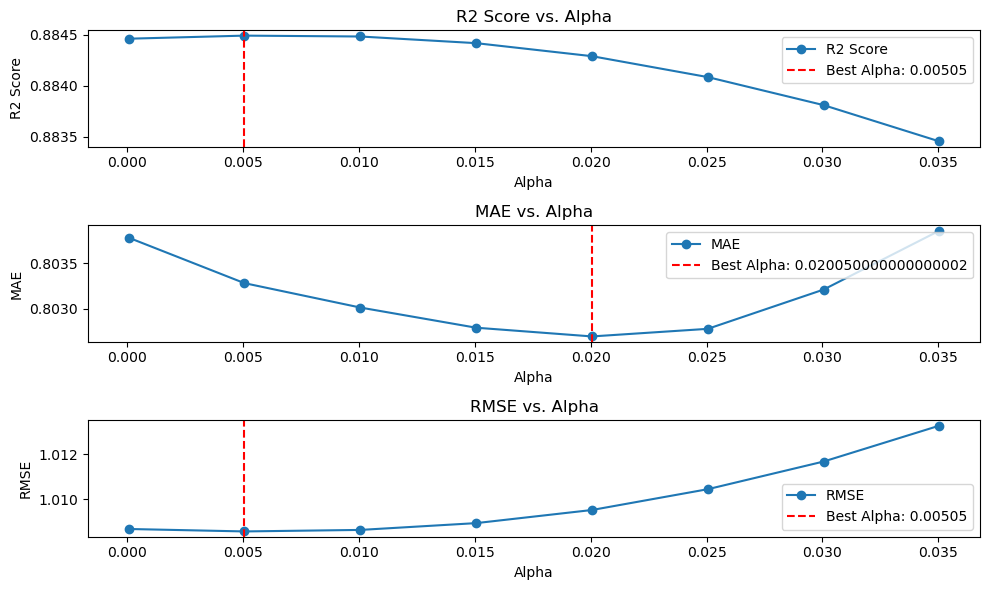

In [113]:
plt.figure(figsize=(10, 6))

# R2 Score
plt.subplot(3, 1, 1)
plt.plot(alphas, r2_scores, label='R2 Score', marker='o')
plt.axvline(x=best_alpha_r2, color='r', linestyle='--', label=f'Best Alpha: {best_alpha_r2}')
plt.title('R2 Score vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.legend()

# MAE
plt.subplot(3, 1, 2)
plt.plot(alphas, mae_scores, label='MAE', marker='o')
plt.axvline(x=best_alpha_mae, color='r', linestyle='--', label=f'Best Alpha: {best_alpha_mae}')
plt.title('MAE vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.legend()

# RMSE
plt.subplot(3, 1, 3)
plt.plot(alphas, rmse_scores, label='RMSE', marker='o')
plt.axvline(x=best_alpha_rmse, color='r', linestyle='--', label=f'Best Alpha: {best_alpha_rmse}')
plt.title('RMSE vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

### Best alpha for R-squared: 0.00505. Best alpha for MAE: 0.020050000000000002. Best alpha for RMSE: 0.00505. R-squared and RMSE are aligned. MAE is less sensitive to outliers compared to RMSE. This suggests that there might be outliers that are influencing the model disproportionately. MAE might prioritize models that perform well on those outliers.

In [115]:
lasso_r2 = Lasso(alpha=best_alpha_r2)
lasso_mae = Lasso(alpha=best_alpha_mae)
lasso_rmse = Lasso(alpha=best_alpha_rmse)

lasso_r2.fit(X_train, y_train)
lasso_mae.fit(X_train, y_train)
lasso_rmse.fit(X_train, y_train)

y_test_pred_r2 = lasso_r2.predict(X_test)
y_test_pred_mae = lasso_mae.predict(X_test)
y_test_pred_rmse = lasso_rmse.predict(X_test)

test_r2_r2 = rsquared(y_test, y_test_pred_r2)
test_r2_mae = mae(y_test, y_test_pred_r2)
test_r2_rmse = rmse(y_test, y_test_pred_r2)

test_mae_r2 = rsquared(y_test, y_test_pred_mae)
test_mae_mae = mae(y_test, y_test_pred_mae)
test_mae_rmse = rmse(y_test, y_test_pred_mae)

test_rmse_r2 = rsquared(y_test, y_test_pred_rmse)
test_rmse_mae = mae(y_test, y_test_pred_rmse)
test_rmse_rmse = rmse(y_test, y_test_pred_rmse)


print(f"test_r2_r2: {test_r2_r2}")
print(f"test_r2_mae: {test_r2_mae}")
print(f"test_r2_rmse: {test_r2_rmse}")

print(f"test_mae_r2: {test_mae_r2}")
print(f"test_mae_mae: {test_mae_mae}")
print(f"test_mae_rmse: {test_mae_rmse}")

print(f"test_rmse_r2: {test_rmse_r2}")
print(f"test_rmse_mae: {test_rmse_mae}")
print(f"test_rmse_rmse: {test_rmse_rmse}")

test_r2_r2: 0.8838471746489255
test_r2_mae: 0.7972401807639303
test_r2_rmse: 0.998072589684139
test_mae_r2: 0.882217585732981
test_mae_mae: 0.8028808806461835
test_mae_rmse: 1.005049531704814
test_rmse_r2: 0.8838471746489255
test_rmse_mae: 0.7972401807639303
test_rmse_rmse: 0.998072589684139


### The three metrics are about the same as from Section 1.2.

In [119]:
test_metrics = np.vstack([y_test_pred_r2, y_test_pred_mae, y_test_pred_rmse]).T
corr_matrix = np.corrcoef(test_metrics, rowvar=False)

print("Pairwise Correlation Matrix:")
print(corr_matrix)

Pairwise Correlation Matrix:
[[1.         0.99988004 1.        ]
 [0.99988004 1.         0.99988004]
 [1.         0.99988004 1.        ]]


### The correlations are close to 1 which suggests that all three metrics led to a very similar model.

In [120]:
def roc_score(y_true: np.array, yhat: np.array, thresh: float = 0.5) -> tuple:
    yhat_binary = (yhat >= thresh).astype(int)
    fp = np.sum((y_true == 0) & (yhat_binary == 1))
    tp = np.sum((y_true == 1) & (yhat_binary == 1))
    fpr = fp / np.sum(y_true == 0) if np.sum(y_true == 0) else 0
    tpr = tp / np.sum(y_true == 1) if np.sum(y_true == 1) else 0
    return fpr, tpr

def precision(y: np.array, yhat: np.array, thresh: float = 0.5) -> float:
    yhat_binary = (yhat >= thresh).astype(int)
    tp = np.sum((y == 1) & (yhat_binary == 1))
    fp = np.sum((y == 0) & (yhat_binary == 1))
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def recall(y: np.array, yhat: np.array, thresh: float = 0.5) -> float:
    yhat_binary = (yhat >= thresh).astype(int)
    tp = np.sum((y == 1) & (yhat_binary == 1))
    fn = np.sum((y == 1) & (yhat_binary == 0))
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def f_score(y: np.array, yhat: np.array, thresh: float = 0.5, beta: float = 1.) -> float:
    prec = precision(y, yhat, thresh)
    rec = recall(y, yhat, thresh)
    return (1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec) if (prec + rec) != 0 else 0

In [121]:
y_test = np.array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1])
yhat_test = np.array([0.367, 0.863, 0.830, 0.277, 0.788, 0.348, 0.601, 0.441, 0.323, 0.280])

precision1 = precision(y_test, yhat_test)
recall1 = recall(y_test, yhat_test)
fscore1 = f_score(y_test, yhat_test)

precision2 = precision_score(y_test, (yhat_test >= 0.5).astype(int), labels=[0, 1], average='binary', pos_label=1)
recall2 = recall_score(y_test, (yhat_test >= 0.5).astype(int), labels=[0, 1], average='binary', pos_label=1)
fscore2 = f1_score(y_test, (yhat_test >= 0.5).astype(int), labels=[0, 1], average='binary', pos_label=1)

In [122]:
print(precision1)
print(recall1)
print(fscore1)

print(precision2)
print(recall2)
print(fscore2)

0.75
0.75
0.75
0.75
0.75
0.75


In [123]:
y_true = np.array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1])
y_hat = np.array([0.367, 0.863, 0.830, 0.277, 0.788, 0.348, 0.601, 0.441, 0.323, 0.280])


thresholds_ROC = [1.863, 0.863, 0.83 , 0.788, 0.601, 0.323, 0.28 , 0.277]
thresholds_P_R_F = [0.277, 0.28, 0.323, 0.348, 0.367, 0.441, 0.601, 0.788, 0.83, 0.863]

fpr_list = []
tpr_list = []
recalls_list = []
precisions_list = []
f1_scores = []

for thresh in thresholds_ROC:
    fpr, tpr = roc_score(y_true, y_hat, thresh)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
   

for thresh in thresholds_P_R_F:
    precision_val = precision(y_true, y_hat, thresh)
    recall_val = recall(y_true, y_hat, thresh)
    f1_score_val = f_score(y_true, y_hat, thresh, beta=1.0)
    precisions_list.append(precision_val)
    recalls_list.append(recall_val)
    f1_scores.append(f1_score_val)

fpr2, tpr2, thresholds2 = roc_curve(y_test, yhat_test)

In [124]:
print(fpr_list)
print(tpr_list)
print(fpr2)
print(tpr2)

[0.0, 0.0, 0.0, 0.16666666666666666, 0.16666666666666666, 0.8333333333333334, 0.8333333333333334, 1.0]
[0.0, 0.25, 0.5, 0.5, 0.75, 0.75, 1.0, 1.0]
[0.         0.         0.         0.16666667 0.16666667 0.83333333
 0.83333333 1.        ]
[0.   0.25 0.5  0.5  0.75 0.75 1.   1.  ]


In [125]:
roc_auc = auc(fpr_list, tpr_list)
precision, recall, thresholds = precision_recall_curve(y_true, y_hat)
pr_auc = average_precision_score(y_true, y_hat)

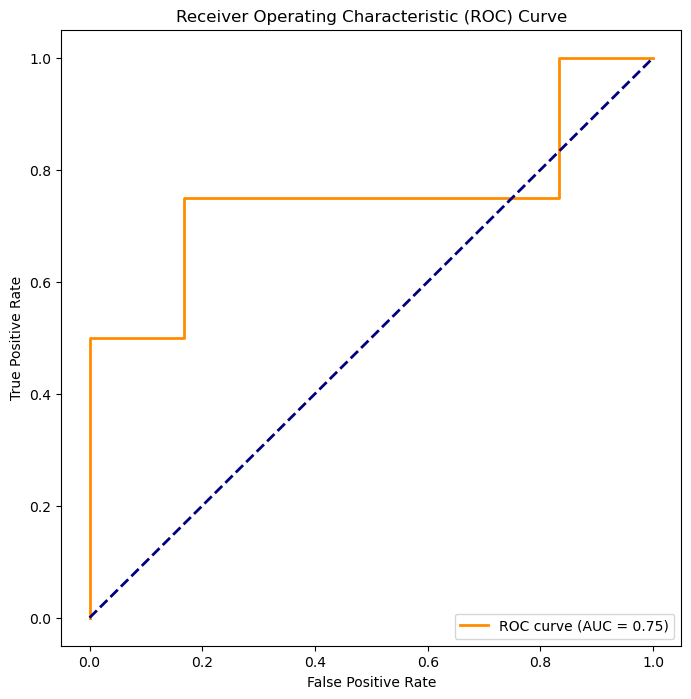

In [126]:
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_list, tpr_list, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

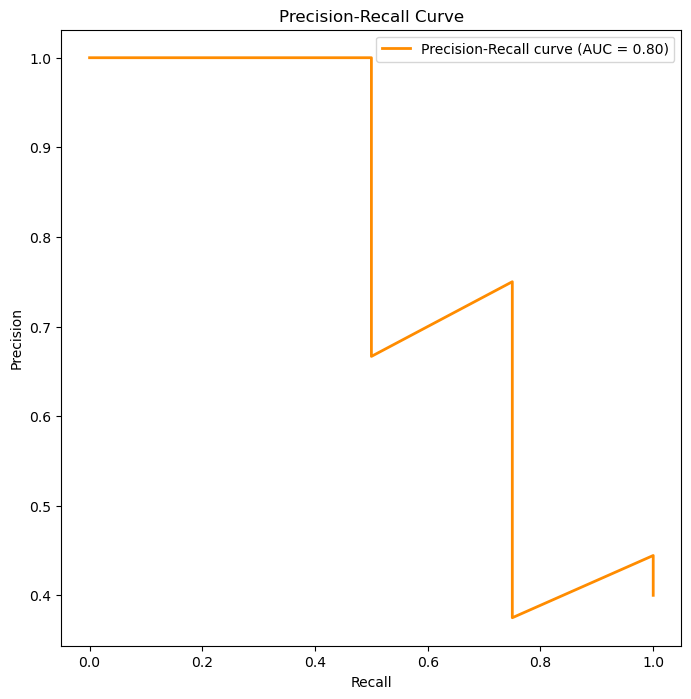

In [127]:
# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

# Show the plot
plt.show()

In [128]:
print(f"AUROC: {roc_auc:.4f}")
print(f"AUPRC: {pr_auc:.4f}")

AUROC: 0.7500
AUPRC: 0.7986
